## Introduction to k-Nearest Neighbors (KNN)

k-Nearest Neighbors (KNN) is a simple, yet powerful algorithm used in machine learning for both classification and regression tasks, though it's more widely used in classification problems. The beauty of KNN lies in its simplicity and effectiveness, especially in cases where the decision boundary is irregular.

### What is k-Nearest Neighbors?

KNN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The algorithm doesn't explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase.

## How Does KNN Work?

The core idea of KNN is that similar things exist in close proximity. In other words, similar things are near to each other.

1. **Choose the number of `k`**: Select the number `k` of the nearest neighbors.
2. **Calculate distances**: Compute the distance between the query instance and all the training samples.
3. **Sort distances**: Sort these distances in ascending order.
4. **Majority vote for classification**: Find the `k` nearest neighbors from the sorted distances. The class most common among these `k` neighbors is assigned to the query instance.
5. **Average for regression**: In the case of regression, the average of the values of these `k` neighbors is the output.

## Benefits of KNN

- **Versatility**: Can be used for both classification and regression.
- **No Assumptions about Data**: Makes no assumption about the underlying data distribution, which is unlike many other algorithms.
- **Simplicity and Intuitiveness**: Easy to understand and implement.

However, KNN can suffer from high computation cost, as it needs to compute the distance of each instance to all the training samples, which can be problematic for large datasets.

### KNN Implementation

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme with a specific style and palette
sns.set_theme(style="whitegrid", palette="pastel")

To visually distinguish different clusters or classes in our dataset, we define a function named `colors`. This function maps each class label to a specific color.


In [49]:
def colors(y):
    if y == 0:
        return "red"
    elif y == 1:
        return "blue"
    elif y == 2:
        return "green"
    else:
        return "yellow"

c = [colors(label) for label in y_combined]

## Generating and Visualizing Complex Data

For our k-Nearest Neighbors implementation, we'll revisit the dataset used in our Decision Trees algorithm. This time, we are combining two types of synthetic datasets: `make_moons` and `make_circles` from Scikit-learn. These datasets help in creating a more complex scenario with four distinct groups.


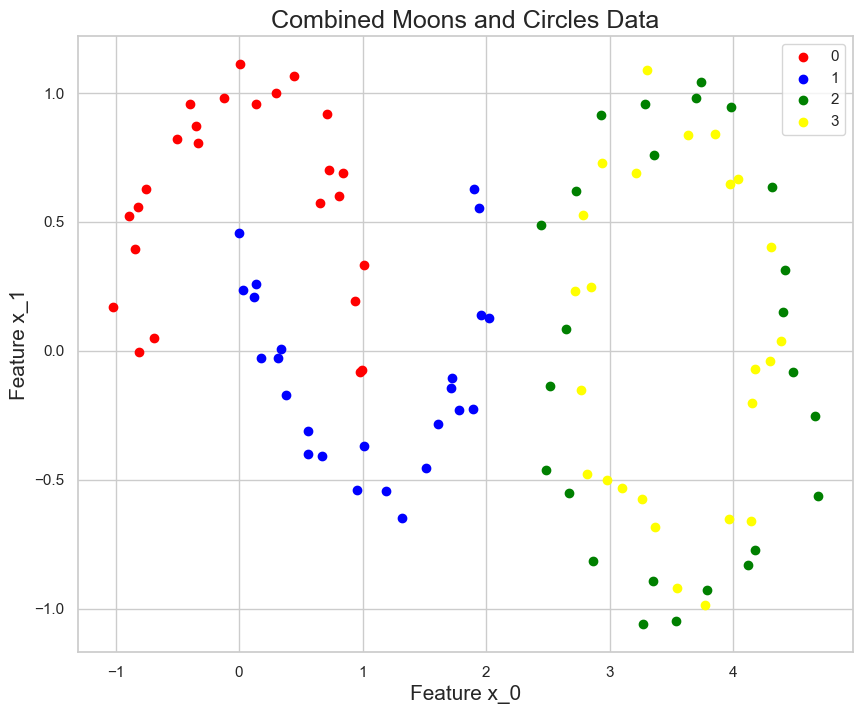

In [51]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

# Generate make_moons and make_circles data
X_moons, y_moons = make_moons(n_samples=50, noise=0.1, random_state=3)
X_circles, y_circles = make_circles(n_samples=50, noise=0.1, random_state=3)

# Offset the circles dataset for better visualization
X_circles[:, 0] += 3.5  # Adjusting x coordinate

# Combine the datasets
X_combined = np.vstack([X_moons, X_circles])
y_combined = np.hstack([y_moons, y_circles + 2])  # Adding 2 to make the labels distinct



# Plotting using the color mapping
plt.figure(figsize=(10, 8))

# Iterate over unique labels and plot each group
for label in np.unique(y_combined):
    plt.scatter(X_combined[y_combined == label, 0], 
                X_combined[y_combined == label, 1], 
                color=colors(label), 
                label=str(label))

plt.xlabel('Feature x_0', fontsize=15)
plt.ylabel('Feature x_1', fontsize=15)
plt.title('Combined Moons and Circles Data', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

Looking at the data without the colorcoding, we have the following plot:

<Figure size 2000x800 with 0 Axes>

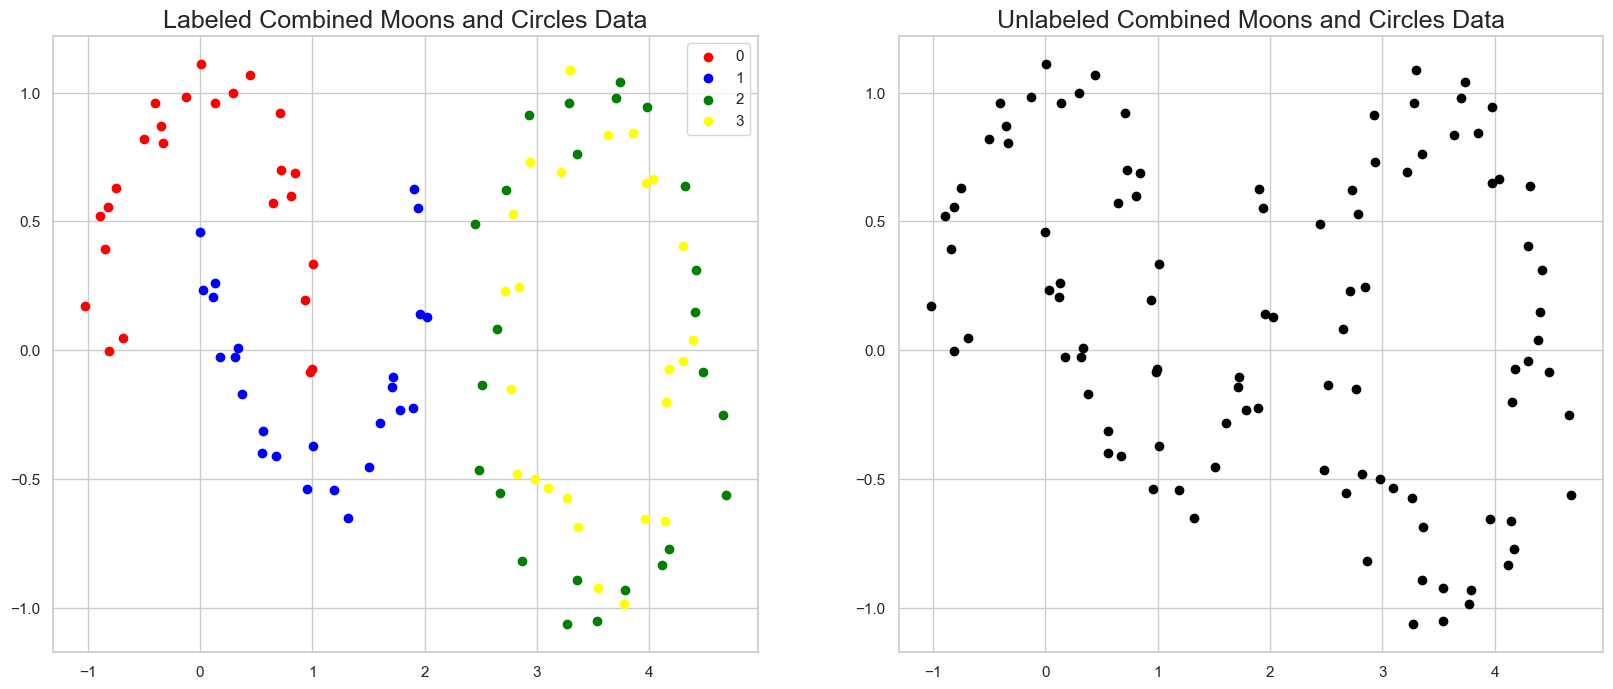

In [53]:
# Creating a figure with two subplots
plt.figure(figsize=(20, 8))

# Creating a figure with two subplots
plt.figure(figsize=(20, 8))

# First subplot: Labeled data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot

# Iterate over unique labels and plot each group
for label in np.unique(y_combined):
    plt.scatter(X_combined[y_combined == label, 0], 
                X_combined[y_combined == label, 1], 
                color=colors(label), 
                label=str(label))

plt.title('Labeled Combined Moons and Circles Data', fontsize=18)
plt.legend()
plt.grid(True)

# Second subplot: Unlabeled data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(X_combined[:, 0], X_combined[:, 1], color='black')
plt.title('Unlabeled Combined Moons and Circles Data', fontsize=18)
plt.grid(True)

# Display the figure
plt.show()

## Initializing Centroids for Clustering

An important step in the KNN algorithm is the initialization of centroids. These centroids are essentially the starting points in our data space around which the clusters will be formed. In our implementation, we'll initialize these centroids by randomly selecting data points from our dataset.

We use the `initialize_centroids` function, which selects a specified number of data points randomly from the dataset and treats these points as the initial centroids. For our example, we start with the assumption that there are four distinct groups in our dataset, hence we initialize four centroids.


In [54]:
def initialize_centroids(X, num_centroids):
    centroids = []
    for k in range(num_centroids):
        i = np.random.randint(0, len(X))
        point = (X[i, 0], X[i, 1], k)
        centroids.append(point)
    return centroids

# Pick 4 centroids randomly
num_centroids = 4
centroids = initialize_centroids(X_combined, num_centroids)


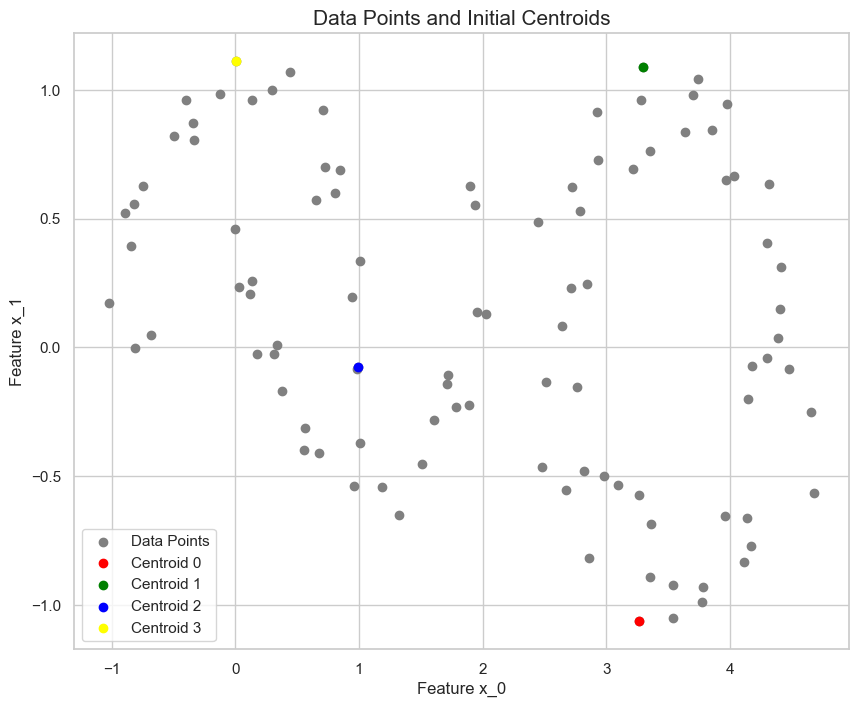

In [57]:
# Plotting data points and centroids
plt.figure(figsize=(10, 8))
plt.scatter(X_combined[:, 0], X_combined[:, 1], color='grey', label='Data Points')

# Define distinct colors for the centroids
centroid_colors = ['red', 'green', 'blue', 'yellow']

# Iterate through centroids to plot them with distinct colors
for idx, (cx, cy, label) in enumerate(centroids):
    plt.scatter(cx, cy, color=centroid_colors[idx], label=f'Centroid {label}')

plt.xlabel('Feature x_0', fontsize=12)
plt.ylabel('Feature x_1', fontsize=12)
plt.title('Data Points and Initial Centroids', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()



Now we have a starting point for each centroid

### K-Nearest Neighbors Algorithm Implementation

This implementation of the K-Nearest Neighbors (KNN) algorithm involves a series of functions designed to classify data points based on their proximity to centroids. The algorithm consists of the following key functions:


In [25]:
def distance(i, X, centroid):
    return np.sqrt(sum((X[i, j] - centroid[j])**2 for j in range(2)))

def assign_label(i, X, centroid):
    distances = np.array([distance(i, X, centroid) for centroid in centroids])
    label = np.argmin(distances)
    return label 

def assign_clusters(X, centroids):
    return [assign_label(i, X, centroids) for i in range(len(X))]

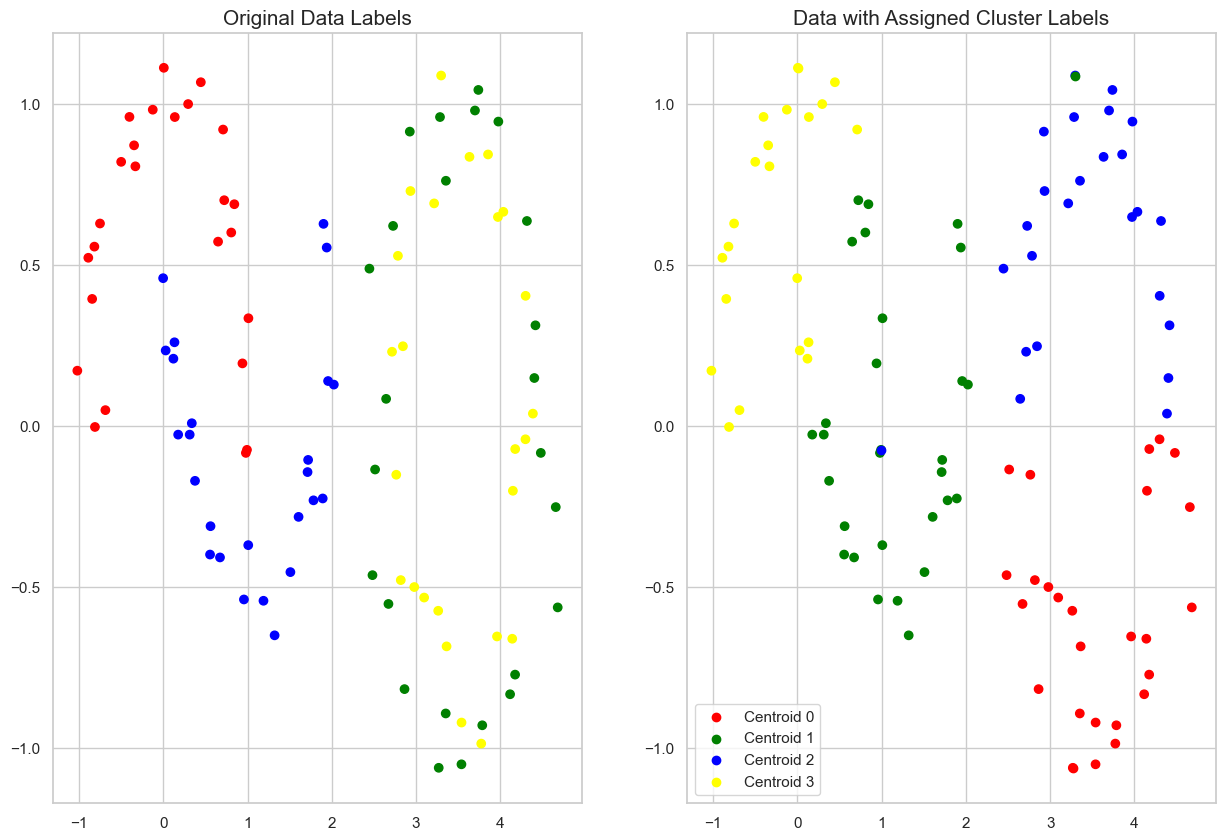

In [58]:
current_labels = assign_clusters(X_combined, centroids)
current_colors = [colors(label) for label in current_labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# First subplot: Original labels
ax1.scatter(X_combined[:, 0], X_combined[:, 1], c=c)
ax1.set_title('Original Data Labels', fontsize=15)

# Second subplot: Assigned labels with centroids
ax2.scatter(X_combined[:, 0], X_combined[:, 1], c=current_colors)
# Iterate through centroids to plot them
for idx, (cx, cy, label) in enumerate(centroids):
    ax2.scatter(cx, cy, color=centroid_colors[idx], label=f'Centroid {label}')
ax2.set_title('Data with Assigned Cluster Labels', fontsize=15)
ax2.legend()

plt.show()


### Analysis of Clustering Plots

The side-by-side comparison of the original and KNN-assigned labels reveals the algorithm's clustering effectiveness. The first subplot displays the initial data distribution, while the second shows data points reclassified according to the nearest centroids. Clearly there is significant error in the second plot. We will investigate further


This function recalculates the positions of centroids based on current cluster assignments. It updates each centroid to the mean position of points assigned to it or retains its original position if no points are assigned.







In [61]:
def update_centroids(X, centroids):
    current_labels = assign_clusters(X, centroids)
    k = len(centroids)
    new_centroids = []

    for i in range(k):
        # Extract points assigned to this centroid
        assigned_points = X[np.array(current_labels) == i]
        
        # Handle case where a centroid has no points assigned
        if len(assigned_points) > 0:
            new_centroid = np.mean(assigned_points, axis=0)
            new_centroids.append((new_centroid[0], new_centroid[1]))
        else:
            # Retain the original centroid position if no points are assigned
            new_centroids.append(centroids[i][:2])

    return new_centroids


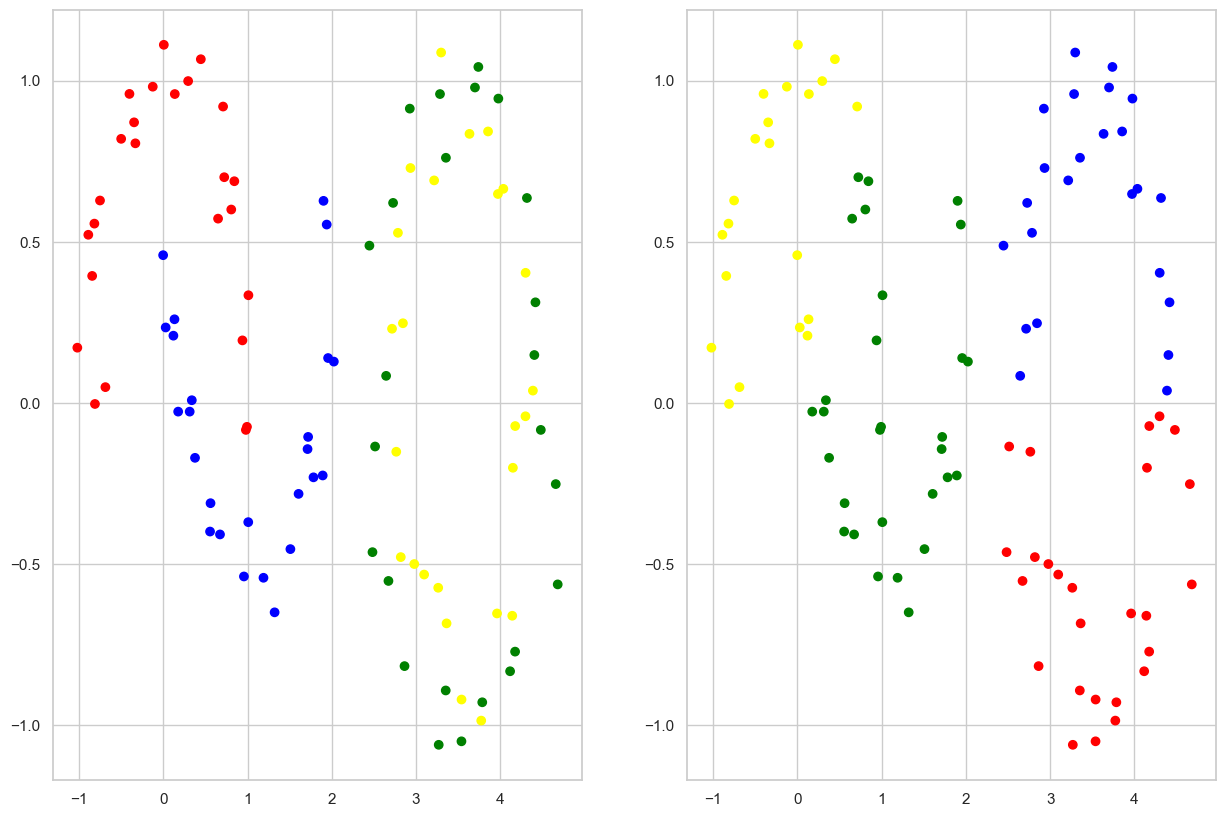

In [63]:
new_centroids = update_centroids(X_combined, centroids)
current_labels = assign_clusters(X_combined, new_centroids)
current_colors = [colors(label) for label in current_labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.scatter(X_combined[:, 0], X_combined[:, 1], c = c)

ax2.scatter(X_combined[:, 0], X_combined[:, 1], c = current_colors)


This function performs K-means clustering on dataset `X` for `k` clusters. It initializes centroids randomly and iteratively updates their positions for a maximum of `max_iter` iterations, finally returning the updated centroids.



In [66]:
def k_means_clustering(X, k, max_iter=100):
    # Initialize centroids randomly
    centroids = []
    for j in range(k):
        i = np.random.randint(0, len(X))
        point = (X[i, 0], X[i, 1], j)
        centroids.append(point)

    # Iterate to update centroid positions
    for _ in range(max_iter):
        centroids = update_centroids(X, centroids)

    return centroids


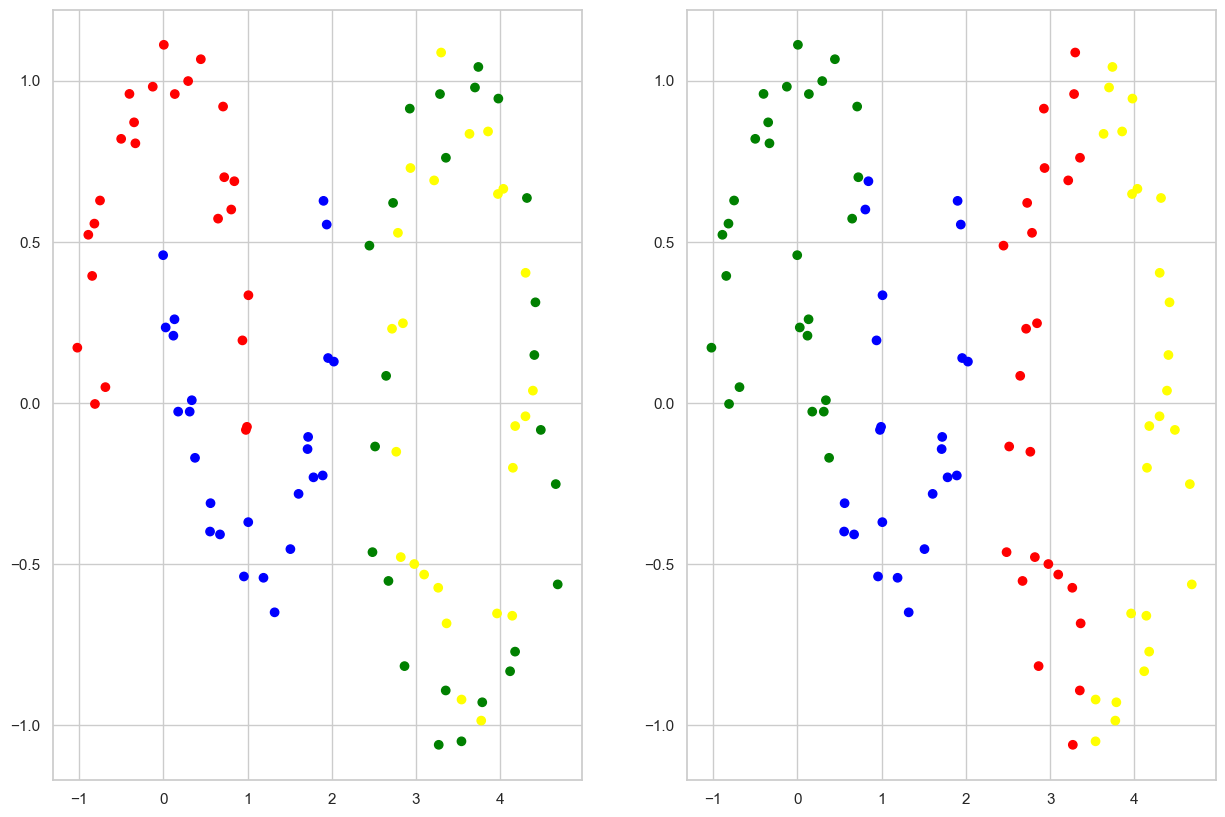

In [73]:
centroids = k_means_clustering(X_combined, 4)
current_labels = assign_clusters(X_combined, new_centroids)
current_colors = [colors(label) for label in current_labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.scatter(X_combined[:, 0], X_combined[:, 1], c = c)

ax2.scatter(X_combined[:, 0], X_combined[:, 1], c = current_colors)

### Analysis of Clustering Graph

The graph reveals major issues in the clustering performance, primarily due to the unique shapes of the clusters. While the algorithm excels at identifying clusters in densely packed data, it struggles with the thin and elongated shapes observed here, leading to several inaccuracies in cluster identification.


### Evaluating Clustering with WCSS

We use the Within-Cluster Sum of Squares (WCSS) to assess the compactness of the clusters formed by the K-means algorithm. A lower WCSS value indicates that data points are closer to their respective centroids, suggesting better clustering.

The `calculate_wcss` function computes the WCSS for a given set of centroids and cluster assignments. It calculates the sum of squared distances of each point in `X` to its assigned centroid.

After obtaining the final centroids and labels from the `k_means_clustering` function, the WCSS is calculated and printed, providing a quantitative measure to evaluate the clustering performance.


In [75]:
def calculate_wcss(X, centroids, labels):
    wcss = 0
    for i in range(len(X)):
        centroid = centroids[labels[i]]
        wcss += np.sum((X[i] - np.array(centroid[:2])) ** 2)
    return wcss

# Calculate the final centroids and labels
final_centroids = k_means_clustering(X_combined, 4)
final_labels = assign_clusters(X_combined, final_centroids)

# Calculate WCSS
wcss = calculate_wcss(X_combined, final_centroids, final_labels)

# Output WCSS
print("WCSS:", wcss)


WCSS: 47.78524289696236


### Interpretation of WCSS Value

The calculated WCSS value appears relatively high, suggesting that the clusters may not be as compact as desired, with data points being farther from their centroids. This indicates that the clustering might not be optimally tight. However, further investigation is necessary to draw definitive conclusions about the clustering effectiveness.
